# Interaction between SuPy and external models

## Introduction

SUEWS can be coupled to other models that provide or require forcing data using the SuPy single timestep running mode. We demonstrate this feature with a simple online anthropogenic heat flux model.

Anthropogenic heat flux ($Q_F$) is an additional term to the surface energy balance in urban areas associated with human activities ([Gabey et al., 2018](https://link.springer.com/article/10.1007%2Fs00704-018-2367-y); [Grimmond, 1992](http://doi.wiley.com/10.1002/joc.3370120506); [Nie et al., 2014](http://linkinghub.elsevier.com/retrieve/pii/S0360132314003321); [2016](https://doi.org/10.1175/JHM-D-16-0173.1); [Sailor, 2011](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/joc.2106)). In most cities, the largest emission source is from buildings ([Hamilton et al., 2009](https://www.sciencedirect.com/science/article/pii/S0360132308001418); [Iamarino et al., 2011](https://rmets.onlinelibrary.wiley.com/doi/10.1002/joc.2390); [Sailor, 2011](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/joc.2106)) and is highly dependent on outdoor ambient air temperature.

### load necessary packages

In [1]:
import supy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

%matplotlib inline
# sp.show_version()

### run `SUEWS` with default settings

### Modern YAML Configuration for Model Coupling

⚠️ **Note**: This tutorial demonstrates external model coupling using low-level SuPy functions and pandas DataFrames. For modern workflows, YAML configurations will provide better integration:

```python
# Future: Modern YAML-based approach for model coupling
# coupling_config = sp.load_coupling_config("qf_coupling.yml")
# external_models = {
#     'anthropogenic_heat': QF_simple,
#     'building_energy': BuildingEnergyModel,
#     'traffic_emissions': TrafficModel
# }
# coupled_simulation = sp.run_coupled_simulation(
#     base_config="site_config.yml",
#     coupling_config=coupling_config,
#     external_models=external_models,
#     timestep_coupling=True
# )
```

**Benefits of YAML-based coupling:**
- **Standardised interfaces**: Consistent data exchange formats
- **Configuration validation**: Automatic checking of coupling parameters
- **Metadata preservation**: Scientific references and model documentation
- **Reproducible workflows**: Version-controlled coupling configurations

This tutorial demonstrates the principles using the current low-level approach.

In [2]:
# Load sample run dataset using modern API
df_state_init, df_forcing = sp.load_sample_data()

print("📊 Sample data loaded using modern load_sample_data() API")
print("✅ Ready for external model coupling")

# turn off the snow module as unnecessary at the sample site
df_state_init.loc[:, "snowuse"] = 0

# copy `df_state_init` as the basis for later simulations
df_state_init_def = df_state_init.copy()

# by default, two years of forcing data are included;
# to save running time for demonstration, we only use one year in this demo
df_forcing = df_forcing.loc["2012"].iloc[1:]

# set QF as zero for later comparison
df_forcing_def = df_forcing.copy()
grid = df_state_init_def.index[0]
df_state_init_def.loc[:, "emissionsmethod"] = 0
df_forcing_def["qf"] = 0

# run supy
df_output, df_state = sp.run_supy(df_forcing_def, df_state_init_def)
df_output_def = df_output.loc[grid, "SUEWS"]

2025-06-15 23:00:12,607 - SuPy - INFO - Loading config from yaml
📊 Sample data loaded using modern load_sample_data() API
✅ Ready for external model coupling
2025-06-15 23:00:14,320 - SuPy - INFO - ====================
2025-06-15 23:00:14,320 - SuPy - INFO - SUEWS version: 2025.6.2.dev99
2025-06-15 23:00:14,321 - SuPy - INFO - Simulation period:
2025-06-15 23:00:14,321 - SuPy - INFO -   Start: 2012-01-01 00:10:00
2025-06-15 23:00:14,321 - SuPy - INFO -   End: 2012-12-31 23:55:00
2025-06-15 23:00:14,322 - SuPy - INFO - 
2025-06-15 23:00:14,322 - SuPy - INFO - No. of grids: 1
2025-06-15 23:00:14,322 - SuPy - INFO - SUEWS is running in serial mode
2025-06-15 23:00:20,246 - SuPy - INFO - Execution time: 5.9 s
2025-06-15 23:00:20,247 - SuPy - INFO - ====================



## a simple QF model: `QF_simple`

### model description

For demonstration purposes we have created a very simple model instead of using the SUEWS $Q_F$ ([Järvi et al. 2011](https://www.sciencedirect.com/science/article/pii/S0022169411006937)) with feedback from outdoor air temperature. The simple $Q_F$ model considers only building heating and cooling:

$$
Q_F=\left\{
                \begin{array}{ll}
                  (T_2-T_C)\times C_B,\;T_2 > T_C\\
                  (T_H-T_2)\times H_B,\;T_2 < T_H\\
                  Q_{F0}
                \end{array}
              \right.
$$

where $T_C$ ($T_H$) is the cooling (heating) threshold temperature of buildings, $𝐶_B$ ($𝐻_B$) is the building cooling (heating) rate, and $𝑄_{F0}$ is the baseline anthropogenic heat. The parameters used are: $𝑇_C$ ($𝑇_H$) set as 20 °C (10 °C), $𝐶_B$ ($𝐻_B$) set as 1.5 $\mathrm{W\ m^{-2}\ K^{-1}}$ (3 $\mathrm{W\ m^{-2}\ K^{-1}}$) and $Q_{F0}$ is set as 0 $\mathrm{W\ m^{-2}}$, implying other building activities (e.g. lighting, water heating, computers) are zero and therefore do not change the temperature or change with temperature.

### implementation

In [3]:
def QF_simple(T2):
    qf_cooling = (T2 - 20) * 5 if T2 > 20 else 0
    qf_heating = (10 - T2) * 10 if T2 < 10 else 0
    qf_res = np.max([qf_heating, qf_cooling]) * 0.3
    return qf_res

Visualise the `QF_simple` model:

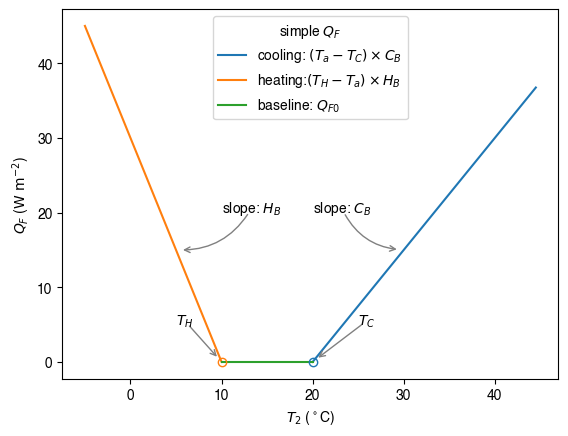

In [ ]:
ser_temp = pd.Series(np.arange(-5, 45, 0.5), index=np.arange(-5, 45, 0.5)).rename(
    "temp_C"
)
ser_qf_heating = (
    ser_temp.loc[-5:10].map(QF_simple).rename(r"heating:$(T_H-T_a) \times H_B$")
)
ser_qf_cooling = (
    ser_temp.loc[20:45].map(QF_simple).rename(r"cooling: $(T_a-T_C) \times C_B$")
)
ser_qf_zero = ser_temp.loc[10:20].map(QF_simple).rename("baseline: $Q_{F0}$")
df_temp_qf = pd.concat(
    [ser_temp, ser_qf_cooling, ser_qf_heating, ser_qf_zero], axis=1
).set_index("temp_C")
ax_qf_func = df_temp_qf.plot()
_ = ax_qf_func.set_xlabel("$T_2$ ($^\circ$C)")
_ = ax_qf_func.set_ylabel("$Q_F$ ($ \mathrm{W \ m^{-2}}$)")
_ = ax_qf_func.legend(title="simple $Q_F$")
_ = ax_qf_func.annotate(
    "$T_C$",
    xy=(20, 0),
    xycoords="data",
    xytext=(25, 5),
    textcoords="data",
    arrowprops=dict(
        arrowstyle="->",
        color="0.5",
        shrinkA=5,
        shrinkB=5,
        patchA=None,
        patchB=None,
        connectionstyle="arc3",
    ),
)

_ = ax_qf_func.annotate(
    "$T_H$",
    xy=(10, 0),
    xycoords="data",
    xytext=(5, 5),
    textcoords="data",
    arrowprops=dict(
        arrowstyle="->",
        color="0.5",
        shrinkA=5,
        shrinkB=5,
        patchA=None,
        patchB=None,
        connectionstyle="arc3",
    ),
)
_ = ax_qf_func.annotate(
    "slope: $C_B$",
    xy=(30, QF_simple(30)),
    xycoords="data",
    xytext=(20, 20),
    textcoords="data",
    arrowprops=dict(
        arrowstyle="->",
        color="0.5",
        shrinkA=5,
        shrinkB=5,
        patchA=None,
        patchB=None,
        connectionstyle="arc3, rad=0.3",
    ),
)
_ = ax_qf_func.annotate(
    "slope: $H_B$",
    xy=(5, QF_simple(5)),
    xycoords="data",
    xytext=(10, 20),
    textcoords="data",
    arrowprops=dict(
        arrowstyle="->",
        color="0.5",
        shrinkA=5,
        shrinkB=5,
        patchA=None,
        patchB=None,
        connectionstyle="arc3, rad=-0.3",
    ),
)
_ = ax_qf_func.plot(10, 0, "o", color="C1", fillstyle="none")
_ = ax_qf_func.plot(20, 0, "o", color="C0", fillstyle="none")

## communication between `supy` and  `QF_simple`

### construct a new coupled function

The coupling between the simple $Q_F$ model and SuPy is done via the low-level function `suews_cal_tstep`, which is an interface function in charge of communications between SuPy frontend and the calculation kernel. By setting SuPy to receive external $Q_F$ as forcing, at each timestep, the simple $Q_F$ model is driven by the SuPy output $T_2$ and provides SuPy with $Q_F$, which thus forms a two-way coupled loop.

In [11]:
# load extra low-level functions from supy to construct interactive functions
from supy._post import pack_df_output_line, pack_df_state
from supy._run import suews_cal_tstep, pack_grid_dict
import numpy as np


def run_supy_qf(df_forcing_test, df_state_init_test):
    grid = df_state_init_test.index[0]
    df_state_init_test.loc[grid, "emissionsmethod"] = 0

    df_forcing_test = df_forcing_test.assign(
        metforcingdata_grid=0,
        ts5mindata_ir=0,
    ).rename(
        # remanae is a workaround to resolve naming inconsistency between
        # suews fortran code interface and input forcing file headers
        columns={
            "%" + "iy": "iy",
            "id": "id",
            "it": "it",
            "imin": "imin",
            "qn": "qn1_obs",
            "qh": "qh_obs",
            "qe": "qe",
            "qs": "qs_obs",
            "qf": "qf_obs",
            "U": "avu1",
            "RH": "avrh",
            "Tair": "temp_c",
            "pres": "press_hpa",
            "rain": "precip",
            "kdown": "avkdn",
            "snow": "snowfrac_obs",
            "ldown": "ldown_obs",
            "fcld": "fcld_obs",
            "Wuh": "wu_m3",
            "xsmd": "xsmd",
            "lai": "lai_obs",
            "kdiff": "kdiff",
            "kdir": "kdir",
            "wdir": "wdir",
        }
    )

    t2_ext = df_forcing_test.iloc[0].temp_c
    qf_ext = QF_simple(t2_ext)

    # initialise dicts for holding results
    dict_state = {}
    dict_output = {}

    # starting tstep
    t_start = df_forcing_test.index[0]
    # convert df to dict with `itertuples` for better performance
    dict_forcing = {row.Index: row._asdict() for row in df_forcing_test.itertuples()}
    # dict_state is used to save model states for later use
    dict_state = {
        (t_start, grid): pack_grid_dict(series_state_init)
        for grid, series_state_init in df_state_init_test.iterrows()
    }

    # just use a single grid run for the test coupling
    for tstep in df_forcing_test.index:
        # load met forcing at `tstep`
        met_forcing_tstep = dict_forcing[tstep]
        # inject `qf_ext` to `met_forcing_tstep`
        met_forcing_tstep["qf_obs"] = qf_ext

        # Add missing variables expected by suews_cal_tstep
        # These are needed for compatibility with the current SUEWS interface
        met_forcing_tstep["len_sim"] = np.array(1, dtype=int)  # Single timestep
        met_forcing_tstep["metforcingblock"] = np.array([[0]], order="F")  # Placeholder
        met_forcing_tstep["flag_test"] = False  # Not in debug mode

        # update model state
        dict_state_start = dict_state[(tstep, grid)]

        dict_state_end, dict_output_tstep = suews_cal_tstep(
            dict_state_start, met_forcing_tstep
        )
        # the fourth to the last is `T2` stored in the result array
        t2_ext = dict_output_tstep["dataoutlinesuews"][-4]
        qf_ext = QF_simple(t2_ext)

        dict_output.update({(tstep, grid): dict_output_tstep})
        dict_state.update({(tstep + tstep.freq, grid): dict_state_end})

    # pack results as easier DataFrames
    df_output_test = pack_df_output_line(dict_output).swaplevel(0, 1)
    df_state_test = pack_df_state(dict_state).swaplevel(0, 1)
    return df_output_test.loc[grid, "SUEWS"], df_state_test

### simulations for summer and winter months

The simulation using SuPy coupled is performed for London 2012. The data analysed are a summer (July) and a winter (December) month. Initially $Q_F$ is 0 $\mathrm{W\ m^{-2}}$ the $T_2$ is determined and used to determine $Q_{F[1]}$ which in turn modifies $T_{2[1]}$ and therefore modifies $Q_{F[2]}$ and the diagnosed $T_{2[2]}$.

#### spin-up run (January to June) for summer simulation

In [12]:
df_output_june, df_state_jul = sp.run_supy(df_forcing.loc[:"2012 6"], df_state_init)

2025-06-15 23:10:57,852 - SuPy - INFO - ====================
2025-06-15 23:10:57,853 - SuPy - INFO - SUEWS version: 2025.6.2.dev99
2025-06-15 23:10:57,853 - SuPy - INFO - Simulation period:
2025-06-15 23:10:57,854 - SuPy - INFO -   Start: 2012-01-01 00:10:00
2025-06-15 23:10:57,854 - SuPy - INFO -   End: 2012-06-30 23:55:00
2025-06-15 23:10:57,854 - SuPy - INFO - 
2025-06-15 23:10:57,855 - SuPy - INFO - No. of grids: 1
2025-06-15 23:10:57,855 - SuPy - INFO - SUEWS is running in serial mode
2025-06-15 23:11:00,957 - SuPy - INFO - Execution time: 3.1 s
2025-06-15 23:11:00,958 - SuPy - INFO - ====================



#### spin-up run (July to October) for winter simulation

In [15]:
df_output_oct, df_state_dec = sp.run_supy(
    df_forcing.loc["2012 7":"2012 11"], df_state_jul
)

2025-06-15 23:14:31,011 - SuPy - INFO - ====================
2025-06-15 23:14:31,012 - SuPy - INFO - SUEWS version: 2025.6.2.dev99
2025-06-15 23:14:31,012 - SuPy - INFO - Simulation period:
2025-06-15 23:14:31,013 - SuPy - INFO -   Start: 2012-07-01 00:00:00
2025-06-15 23:14:31,013 - SuPy - INFO -   End: 2012-11-30 23:55:00
2025-06-15 23:14:31,014 - SuPy - INFO - 
2025-06-15 23:14:31,014 - SuPy - INFO - No. of grids: 1
2025-06-15 23:14:31,015 - SuPy - INFO - SUEWS is running in serial mode
2025-06-15 23:14:33,960 - SuPy - INFO - Execution time: 2.9 s
2025-06-15 23:14:33,971 - SuPy - INFO - ====================



#### coupled simulation

In [16]:
# df_output_test_summer, df_state_summer_test = run_supy_qf(
#     df_forcing.loc["2012-07"], df_state_jul.copy()
# )
# df_output_test_winter, df_state_winter_test = run_supy_qf(
#     df_forcing.loc["2012-12"], df_state_dec.copy()
# )

### examine the results

#### sumer

In [17]:
# var = "QF"
# var_label = "$Q_F$ ($ \mathrm{W \ m^{-2}}$)"
# var_label_right = "$\Delta Q_F$ ($ \mathrm{W \ m^{-2}}$)"
# period = "2012-07"
# df_test = df_output_test_summer
# y1 = df_test.loc[period, var].rename("qf_simple")
# y2 = df_output_def.loc[period, var].rename("suews")
# y3 = (y1 - y2).rename("diff")
# df_plot = pd.concat([y1, y2, y3], axis=1)
# ax = df_plot.plot(secondary_y="diff")
# _ = ax.set_ylabel(var_label)
# _ = ax.right_ax.set_ylabel(var_label_right)
# lines = ax.get_lines() + ax.right_ax.get_lines()
# _ = ax.legend(lines, [l.get_label() for l in lines], loc="best")

In [18]:
# var = "T2"
# var_label = "$T_2$ ($^{\circ}$C)"
# var_label_right = "$\Delta T_2$ ($^{\circ}$C)"
# period = "2012-07"
# df_test = df_output_test_summer
# y1 = df_test.loc[period, var].rename("qf_simple")
# y2 = df_output_def.loc[period, var].rename("suews")
# y3 = (y1 - y2).rename("diff")
# df_plot = pd.concat([y1, y2, y3], axis=1)
# ax = df_plot.plot(secondary_y="diff")
# _ = ax.set_ylabel(var_label)
# _ = ax.right_ax.set_ylabel(var_label_right)
# lines = ax.get_lines() + ax.right_ax.get_lines()
# _ = ax.legend(lines, [l.get_label() for l in lines], loc="best")

#### winter

In [19]:
# var = "QF"
# var_label = "$Q_F$ ($ \mathrm{W \ m^{-2}}$)"
# var_label_right = "$\Delta Q_F$ ($ \mathrm{W \ m^{-2}}$)"
# period = "2012 12"
# df_test = df_output_test_winter
# y1 = df_test.loc[period, var].rename("qf_simple")
# y2 = df_output_def.loc[period, var].rename("suews")
# y3 = (y1 - y2).rename("diff")
# df_plot = pd.concat([y1, y2, y3], axis=1)
# ax = df_plot.plot(secondary_y="diff")
# _ = ax.set_ylabel(var_label)
# _ = ax.right_ax.set_ylabel(var_label_right)
# lines = ax.get_lines() + ax.right_ax.get_lines()
# _ = ax.legend(lines, [l.get_label() for l in lines], loc="best")

In [20]:
# var = "T2"
# var_label = "$T_2$ ($^{\circ}$C)"
# var_label_right = "$\Delta T_2$ ($^{\circ}$C)"
# period = "2012 12"
# df_test = df_output_test_winter
# y1 = df_test.loc[period, var].rename("qf_simple")
# y2 = df_output_def.loc[period, var].rename("suews")
# y3 = (y1 - y2).rename("diff")
# df_plot = pd.concat([y1, y2, y3], axis=1)
# ax = df_plot.plot(secondary_y="diff")
# _ = ax.set_ylabel(var_label)
# _ = ax.right_ax.set_ylabel(var_label_right)
# lines = ax.get_lines() + ax.right_ax.get_lines()
# _ = ax.legend(lines, [l.get_label() for l in lines], loc="center right")

#### comparison in $\Delta Q_F$-$\Delta T2$ feedback between summer and winter

In [21]:
# # filter results using `where` to choose periods when `QF_simple` is effective
# # (i.e. activated by outdoor air temperatures)
# df_diff_summer = (
#     (df_output_test_summer - df_output_def)
#     .where(df_output_def.T2 > 20, np.nan)
#     .dropna(how="all", axis=0)
# )
# df_diff_winter = (
#     (df_output_test_winter - df_output_def)
#     .where(df_output_test_winter.T2 < 10, np.nan)
#     .dropna(how="all", axis=0)
#     .loc["20121215":]
# )


# df_diff_season = pd.concat(
#     [
#         df_diff_winter.assign(season="winter"),
#         df_diff_summer.assign(season="summer"),
#     ]
# ).loc[:, ["season", "QF", "T2"]]
# g = sns.lmplot(
#     data=df_diff_season,
#     x="QF",
#     y="T2",
#     hue="season",
#     height=4,
#     truncate=False,
#     markers="o",
#     legend_out=False,
#     scatter_kws={
#         "s": 1,
#         "zorder": 0,
#         "alpha": 0.8,
#     },
#     line_kws={"zorder": 6, "linestyle": "--"},
# )
# _ = g.set_axis_labels(
#     "$\Delta Q_F$ ($ \mathrm{W \ m^{-2}}$)",
#     "$\Delta T_2$ ($^{\circ}$C)",
# )
# _ = g.ax.legend(markerscale=4)
# _ = g.despine(top=False, right=False)

The above figure indicates a positive feedback, as $Q_F$ is increased there is an elevated $T_2$ but with different magnitudes given the non-linearlity in the SUEWS modelling system. Of particular note is the positive feedback loop under warm air temperatures: the anthropogenic heat emissions increase which in turn elevates the outdoor air temperature causing yet more anthropogenic heat release. Note that London is relatively cool so the enhancement is much less than it would be in warmer cities.